In [24]:
from collections import defaultdict
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
# gensim
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

from mongo_client import mongo_client

In [2]:
db = mongo_client.get_database('historical_events')
collection = db.get_collection('event_descriptions')

In [6]:
stop_words = list(ENGLISH_STOP_WORDS) + [
    'abc', 'ampndash', 'ampamp', 'amp', 'ampampndash', 'ampquot', 'ampquotthe', 'ampref',
    'http', 'href', 'html', 'htm', 'www', 'com'
]
count_vectorizer = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.9,
                                   stop_words=stop_words, token_pattern="\\b[a-z][a-z]+\\b")
docs = [doc['description'].split('{{')[0] for doc in collection.find()]
count_vectorizer.fit(docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.001,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['ie', 'become', 'two', 'you', 'anything', 'hers', 'seem', 'fifteen', 'still', 'hereby', 'him', 'eg', 'beyond', 'sometime', 'therein', 'describe', 'somewhere', 'under', 'into', 'whence', 'the', 'almost', 'few', 'an', 'own', 'three', 'formerly', 'often', 'each', 'though', 'side', 'together...', 'ampamp', 'amp', 'ampampndash', 'ampquot', 'ampquotthe', 'ampref', 'http', 'href', 'html', 'htm'],
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [7]:
count_vectorizer.get_feature_names()

['abbey',
 'abdicates',
 'aboard',
 'abolished',
 'abolishes',
 'abraham',
 'academy',
 'accepts',
 'accident',
 'according',
 'accused',
 'act',
 'acting',
 'action',
 'adams',
 'address',
 'administration',
 'admiral',
 'admitted',
 'adolf',
 'adopted',
 'adopts',
 'advance',
 'affair',
 'afghanistan',
 'africa',
 'african',
 'age',
 'agency',
 'agents',
 'agree',
 'agreement',
 'agrees',
 'aid',
 'air',
 'aircraft',
 'airlines',
 'airplane',
 'airport',
 'airways',
 'al',
 'alabama',
 'alaska',
 'albania',
 'albert',
 'album',
 'alexander',
 'alfred',
 'algeria',
 'ali',
 'alleged',
 'alliance',
 'allied',
 'allies',
 'allowed',
 'allowing',
 'alpha',
 'ambassador',
 'amendment',
 'america',
 'american',
 'americans',
 'amsterdam',
 'andrew',
 'angeles',
 'anglo',
 'animated',
 'anne',
 'annexes',
 'anniversary',
 'announce',
 'announced',
 'announces',
 'annual',
 'anthony',
 'anti',
 'antonio',
 'apartheid',
 'apollo',
 'appearance',
 'appears',
 'appointed',
 'appoints',
 'approa

In [8]:
counts = count_vectorizer.transform(docs).transpose()
counts.shape

(1802, 23911)

In [9]:
corpus = matutils.Sparse2Corpus(counts)

In [10]:
id2word = {id: word for word, id in count_vectorizer.vocabulary_.items()}

In [11]:
num_topics = 16
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, minimum_probability=0.01, id2word=id2word, passes=10)

2018-05-30 20:54:19,368 : INFO : using symmetric alpha at 0.0625
2018-05-30 20:54:19,372 : INFO : using symmetric eta at 0.0625
2018-05-30 20:54:19,376 : INFO : using serial LDA version on this node
2018-05-30 20:54:19,387 : INFO : running online (multi-pass) LDA training, 16 topics, 10 passes over the supplied corpus of 23911 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-05-30 20:54:19,399 : INFO : PROGRESS: pass 0, at document #2000/23911
2018-05-30 20:54:19,945 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:19,950 : INFO : topic #0 (0.062): 0.018*"german" + 0.015*"battle" + 0.013*"international" + 0.012*"begins" + 0.012*"united" + 0.012*"paris" + 0.010*"war" + 0.010*"kingdom" + 0.009*"opens" + 0.009*"ottoman"
2018-05-30 20:54:19,951 : INFO : topic #11 (0.062): 0.017*"february" + 0.016*"new" + 0.016*"kills" + 0.014*"russian" + 

2018-05-30 20:54:22,089 : INFO : topic #14 (0.062): 0.041*"crashes" + 0.022*"california" + 0.018*"war" + 0.014*"germany" + 0.013*"southern" + 0.012*"killed" + 0.012*"eventually" + 0.012*"rock" + 0.011*"dc" + 0.011*"months"
2018-05-30 20:54:22,090 : INFO : topic diff=0.202410, rho=0.408248
2018-05-30 20:54:22,099 : INFO : PROGRESS: pass 0, at document #14000/23911
2018-05-30 20:54:22,465 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:22,470 : INFO : topic #4 (0.062): 0.051*"democratic" + 0.040*"election" + 0.034*"presidential" + 0.029*"program" + 0.023*"republican" + 0.019*"ii" + 0.018*"algeria" + 0.017*"arab" + 0.016*"pope" + 0.015*"john"
2018-05-30 20:54:22,471 : INFO : topic #2 (0.062): 0.053*"war" + 0.042*"iraq" + 0.022*"treaty" + 0.021*"forces" + 0.019*"agreement" + 0.016*"iraqi" + 0.015*"ending" + 0.014*"sign" + 0.014*"troops" + 0.014*"peace"
2018-05-30 20:54:22,471 : INFO : topic #6 (0.062): 0.060*"south" + 0.037*"minister" + 0.037*"

2018-05-30 20:54:26,062 : INFO : topic #15 (0.062): 0.081*"president" + 0.024*"la" + 0.023*"act" + 0.021*"known" + 0.021*"congress" + 0.019*"john" + 0.018*"elected" + 0.017*"revolutionary" + 0.015*"passes" + 0.015*"jean"
2018-05-30 20:54:26,063 : INFO : topic #4 (0.062): 0.038*"defeats" + 0.033*"spain" + 0.032*"john" + 0.027*"ii" + 0.027*"pope" + 0.025*"king" + 0.022*"james" + 0.021*"ship" + 0.020*"charles" + 0.020*"frederick"
2018-05-30 20:54:26,064 : INFO : topic diff=0.207351, rho=0.288675
2018-05-30 20:54:26,075 : INFO : PROGRESS: pass 1, at document #2000/23911
2018-05-30 20:54:26,371 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:26,376 : INFO : topic #13 (0.062): 0.050*"king" + 0.042*"england" + 0.017*"force" + 0.017*"attack" + 0.016*"swedish" + 0.016*"scotland" + 0.015*"father" + 0.014*"leaves" + 0.014*"dies" + 0.014*"succeeded"
2018-05-30 20:54:26,376 : INFO : topic #5 (0.062): 0.044*"french" + 0.042*"english" + 0.021*"fort" + 0.0

2018-05-30 20:54:28,002 : INFO : topic #5 (0.062): 0.031*"french" + 0.020*"communist" + 0.019*"police" + 0.017*"party" + 0.017*"paul" + 0.016*"english" + 0.015*"army" + 0.013*"america" + 0.012*"leader" + 0.011*"capital"
2018-05-30 20:54:28,002 : INFO : topic diff=0.171882, rho=0.267687
2018-05-30 20:54:28,009 : INFO : PROGRESS: pass 1, at document #14000/23911
2018-05-30 20:54:28,284 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:28,290 : INFO : topic #15 (0.062): 0.163*"president" + 0.031*"elected" + 0.029*"national" + 0.019*"uk" + 0.016*"declares" + 0.014*"independence" + 0.014*"congress" + 0.013*"act" + 0.013*"state" + 0.012*"government"
2018-05-30 20:54:28,291 : INFO : topic #6 (0.062): 0.062*"south" + 0.051*"minister" + 0.049*"prime" + 0.039*"north" + 0.038*"vietnam" + 0.022*"japan" + 0.021*"africa" + 0.016*"million" + 0.016*"richard" + 0.013*"war"
2018-05-30 20:54:28,291 : INFO : topic #11 (0.062): 0.058*"killing" + 0.053*"people" + 

2018-05-30 20:54:30,612 : INFO : topic #4 (0.062): 0.037*"john" + 0.037*"defeats" + 0.037*"spain" + 0.032*"charles" + 0.031*"ii" + 0.030*"james" + 0.026*"pope" + 0.025*"king" + 0.020*"ship" + 0.018*"frederick"
2018-05-30 20:54:30,613 : INFO : topic diff=0.144235, rho=0.267687
2018-05-30 20:54:30,623 : INFO : PROGRESS: pass 2, at document #2000/23911
2018-05-30 20:54:30,899 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:30,904 : INFO : topic #11 (0.062): 0.044*"killing" + 0.040*"people" + 0.036*"kills" + 0.025*"earthquake" + 0.024*"iii" + 0.022*"pennsylvania" + 0.021*"roman" + 0.017*"city" + 0.017*"river" + 0.016*"near"
2018-05-30 20:54:30,904 : INFO : topic #5 (0.062): 0.043*"english" + 0.043*"french" + 0.022*"fort" + 0.021*"america" + 0.021*"rebellion" + 0.018*"colony" + 0.017*"capital" + 0.016*"army" + 0.015*"revolution" + 0.015*"troops"
2018-05-30 20:54:30,905 : INFO : topic #2 (0.062): 0.105*"war" + 0.069*"battle" + 0.035*"british" + 0

2018-05-30 20:54:32,376 : INFO : topic diff=0.104699, rho=0.258583
2018-05-30 20:54:32,385 : INFO : PROGRESS: pass 2, at document #14000/23911
2018-05-30 20:54:32,660 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:32,664 : INFO : topic #9 (0.062): 0.099*"soviet" + 0.077*"union" + 0.037*"military" + 0.028*"coup" + 0.024*"european" + 0.018*"iran" + 0.018*"life" + 0.018*"launches" + 0.015*"russian" + 0.015*"russia"
2018-05-30 20:54:32,665 : INFO : topic #7 (0.062): 0.069*"government" + 0.032*"flight" + 0.029*"civil" + 0.024*"board" + 0.023*"island" + 0.022*"east" + 0.022*"takes" + 0.022*"turkey" + 0.021*"india" + 0.021*"new"
2018-05-30 20:54:32,668 : INFO : topic #4 (0.062): 0.044*"democratic" + 0.032*"election" + 0.029*"john" + 0.029*"presidential" + 0.028*"ii" + 0.026*"program" + 0.023*"spain" + 0.022*"republican" + 0.022*"arab" + 0.021*"defeats"
2018-05-30 20:54:32,669 : INFO : topic #8 (0.062): 0.040*"opens" + 0.035*"released" + 0.028*"an

2018-05-30 20:54:34,900 : INFO : topic diff=0.090573, rho=0.258583
2018-05-30 20:54:34,908 : INFO : PROGRESS: pass 3, at document #2000/23911
2018-05-30 20:54:35,162 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:35,167 : INFO : topic #3 (0.062): 0.029*"formed" + 0.028*"league" + 0.026*"seven" + 0.023*"football" + 0.023*"years" + 0.020*"club" + 0.019*"grand" + 0.017*"radio" + 0.017*"chicago" + 0.016*"convention"
2018-05-30 20:54:35,168 : INFO : topic #15 (0.062): 0.091*"president" + 0.026*"act" + 0.022*"national" + 0.021*"la" + 0.020*"elected" + 0.020*"congress" + 0.020*"parliament" + 0.019*"independence" + 0.017*"declares" + 0.016*"assembly"
2018-05-30 20:54:35,169 : INFO : topic #6 (0.062): 0.070*"north" + 0.052*"south" + 0.044*"carolina" + 0.039*"minister" + 0.035*"louis" + 0.033*"prime" + 0.027*"japan" + 0.017*"canada" + 0.016*"australia" + 0.016*"million"
2018-05-30 20:54:35,170 : INFO : topic #4 (0.062): 0.036*"john" + 0.034*"defeats

2018-05-30 20:54:36,856 : INFO : topic #5 (0.062): 0.029*"party" + 0.024*"police" + 0.024*"french" + 0.023*"communist" + 0.021*"massacre" + 0.018*"army" + 0.017*"paul" + 0.016*"leader" + 0.015*"killed" + 0.014*"america"
2018-05-30 20:54:36,856 : INFO : topic #6 (0.062): 0.065*"minister" + 0.062*"south" + 0.057*"prime" + 0.041*"north" + 0.039*"vietnam" + 0.028*"japan" + 0.021*"million" + 0.021*"africa" + 0.016*"richard" + 0.016*"canada"
2018-05-30 20:54:36,857 : INFO : topic #10 (0.062): 0.095*"new" + 0.044*"york" + 0.030*"city" + 0.029*"world" + 0.020*"win" + 0.019*"court" + 0.019*"federal" + 0.016*"office" + 0.015*"party" + 0.014*"cup"
2018-05-30 20:54:36,858 : INFO : topic #12 (0.062): 0.191*"united" + 0.133*"states" + 0.037*"kingdom" + 0.034*"nations" + 0.028*"space" + 0.022*"council" + 0.019*"time" + 0.017*"security" + 0.012*"published" + 0.012*"final"
2018-05-30 20:54:36,858 : INFO : topic #15 (0.062): 0.157*"president" + 0.031*"national" + 0.029*"elected" + 0.019*"independence" +

2018-05-30 20:54:39,254 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:39,260 : INFO : topic #8 (0.062): 0.043*"opens" + 0.040*"london" + 0.032*"publishes" + 0.032*"virginia" + 0.022*"san" + 0.022*"william" + 0.020*"robert" + 0.019*"california" + 0.017*"strike" + 0.016*"england"
2018-05-30 20:54:39,260 : INFO : topic #0 (0.062): 0.059*"france" + 0.042*"royal" + 0.035*"emperor" + 0.031*"paris" + 0.027*"held" + 0.025*"house" + 0.025*"begins" + 0.024*"international" + 0.023*"fleet" + 0.018*"navy"
2018-05-30 20:54:39,261 : INFO : topic #15 (0.062): 0.090*"president" + 0.027*"act" + 0.023*"parliament" + 0.022*"national" + 0.021*"independence" + 0.021*"la" + 0.020*"congress" + 0.019*"elected" + 0.017*"assembly" + 0.017*"declares"
2018-05-30 20:54:39,262 : INFO : topic #14 (0.062): 0.049*"spanish" + 0.031*"sweden" + 0.028*"germany" + 0.027*"thomas" + 0.025*"county" + 0.016*"west" + 0.016*"denmark" + 0.014*"december" + 0.013*"oldest" + 0.013*"vict

2018-05-30 20:54:41,196 : INFO : topic #14 (0.062): 0.040*"crashes" + 0.040*"germany" + 0.029*"west" + 0.017*"spanish" + 0.017*"murder" + 0.016*"injured" + 0.015*"sweden" + 0.013*"rock" + 0.012*"southern" + 0.012*"thomas"
2018-05-30 20:54:41,197 : INFO : topic #7 (0.062): 0.070*"government" + 0.032*"civil" + 0.030*"takes" + 0.029*"flight" + 0.028*"india" + 0.026*"east" + 0.024*"island" + 0.023*"board" + 0.022*"turkey" + 0.021*"israel"
2018-05-30 20:54:41,198 : INFO : topic #10 (0.062): 0.096*"new" + 0.045*"york" + 0.032*"city" + 0.029*"world" + 0.020*"win" + 0.019*"court" + 0.019*"federal" + 0.016*"office" + 0.014*"party" + 0.014*"cup"
2018-05-30 20:54:41,199 : INFO : topic #6 (0.062): 0.065*"minister" + 0.062*"south" + 0.057*"prime" + 0.041*"north" + 0.039*"vietnam" + 0.028*"japan" + 0.022*"million" + 0.021*"africa" + 0.018*"canada" + 0.017*"australia"
2018-05-30 20:54:41,199 : INFO : topic #1 (0.062): 0.047*"founded" + 0.037*"china" + 0.037*"republic" + 0.036*"www" + 0.031*"universit

2018-05-30 20:54:43,457 : INFO : PROGRESS: pass 5, at document #2000/23911
2018-05-30 20:54:44,371 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:44,389 : INFO : topic #12 (0.062): 0.200*"united" + 0.158*"states" + 0.051*"kingdom" + 0.031*"published" + 0.021*"time" + 0.020*"constitution" + 0.017*"council" + 0.015*"nations" + 0.013*"completed" + 0.013*"construction"
2018-05-30 20:54:44,390 : INFO : topic #3 (0.062): 0.030*"formed" + 0.028*"league" + 0.026*"seven" + 0.023*"football" + 0.023*"years" + 0.021*"club" + 0.018*"grand" + 0.017*"radio" + 0.017*"prison" + 0.017*"national"
2018-05-30 20:54:44,393 : INFO : topic #10 (0.062): 0.119*"new" + 0.050*"york" + 0.039*"city" + 0.025*"world" + 0.021*"governor" + 0.021*"massachusetts" + 0.015*"court" + 0.014*"state" + 0.013*"boston" + 0.013*"women"
2018-05-30 20:54:44,399 : INFO : topic #1 (0.062): 0.123*"founded" + 0.053*"university" + 0.043*"established" + 0.034*"www" + 0.033*"china" + 0.030*"c

2018-05-30 20:54:47,364 : INFO : topic #13 (0.062): 0.031*"england" + 0.030*"nuclear" + 0.027*"king" + 0.025*"year" + 0.023*"dies" + 0.021*"dead" + 0.021*"death" + 0.021*"air" + 0.020*"force" + 0.018*"old"
2018-05-30 20:54:47,365 : INFO : topic #15 (0.062): 0.153*"president" + 0.029*"national" + 0.028*"elected" + 0.019*"independence" + 0.018*"declares" + 0.018*"uk" + 0.016*"act" + 0.016*"government" + 0.015*"state" + 0.014*"congress"
2018-05-30 20:54:47,365 : INFO : topic #7 (0.062): 0.069*"government" + 0.034*"civil" + 0.031*"takes" + 0.028*"india" + 0.027*"flight" + 0.026*"east" + 0.024*"island" + 0.023*"board" + 0.022*"turkey" + 0.020*"israel"
2018-05-30 20:54:47,366 : INFO : topic #3 (0.062): 0.040*"wins" + 0.028*"years" + 0.025*"prison" + 0.024*"radio" + 0.022*"series" + 0.021*"national" + 0.020*"sentenced" + 0.020*"pakistan" + 0.020*"league" + 0.017*"bank"
2018-05-30 20:54:47,367 : INFO : topic #6 (0.062): 0.065*"minister" + 0.062*"south" + 0.057*"prime" + 0.042*"north" + 0.039*"

2018-05-30 20:54:50,280 : INFO : PROGRESS: pass 6, at document #2000/23911
2018-05-30 20:54:50,801 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:50,809 : INFO : topic #7 (0.062): 0.047*"civil" + 0.042*"government" + 0.041*"india" + 0.036*"island" + 0.031*"takes" + 0.029*"east" + 0.025*"company" + 0.025*"indian" + 0.021*"place" + 0.021*"town"
2018-05-30 20:54:50,812 : INFO : topic #4 (0.062): 0.040*"john" + 0.035*"charles" + 0.032*"defeats" + 0.032*"james" + 0.031*"spain" + 0.030*"ii" + 0.025*"king" + 0.023*"pope" + 0.021*"ref" + 0.020*"irish"
2018-05-30 20:54:50,815 : INFO : topic #1 (0.062): 0.123*"founded" + 0.053*"university" + 0.043*"established" + 0.035*"china" + 0.034*"www" + 0.030*"college" + 0.026*"school" + 0.025*"com" + 0.023*"american" + 0.019*"church"
2018-05-30 20:54:50,818 : INFO : topic #15 (0.062): 0.091*"president" + 0.028*"act" + 0.025*"parliament" + 0.022*"independence" + 0.021*"national" + 0.020*"la" + 0.019*"elected" 

2018-05-30 20:54:52,840 : INFO : topic #13 (0.062): 0.032*"england" + 0.029*"nuclear" + 0.028*"king" + 0.026*"year" + 0.023*"dies" + 0.022*"death" + 0.021*"force" + 0.021*"dead" + 0.020*"air" + 0.019*"old"
2018-05-30 20:54:52,840 : INFO : topic #3 (0.062): 0.039*"wins" + 0.027*"years" + 0.025*"prison" + 0.024*"radio" + 0.022*"series" + 0.022*"national" + 0.020*"sentenced" + 0.020*"pakistan" + 0.020*"league" + 0.017*"bank"
2018-05-30 20:54:52,843 : INFO : topic #10 (0.062): 0.099*"new" + 0.045*"york" + 0.035*"city" + 0.029*"world" + 0.019*"win" + 0.019*"court" + 0.019*"federal" + 0.016*"office" + 0.014*"party" + 0.014*"general"
2018-05-30 20:54:52,846 : INFO : topic #8 (0.062): 0.052*"opens" + 0.034*"released" + 0.029*"london" + 0.025*"announces" + 0.024*"california" + 0.023*"film" + 0.023*"san" + 0.020*"strike" + 0.016*"goes" + 0.015*"man"
2018-05-30 20:54:52,848 : INFO : topic #1 (0.062): 0.049*"founded" + 0.040*"china" + 0.036*"www" + 0.036*"republic" + 0.031*"university" + 0.028*"af

2018-05-30 20:54:55,561 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:54:55,566 : INFO : topic #2 (0.062): 0.114*"war" + 0.067*"battle" + 0.038*"british" + 0.038*"forces" + 0.033*"troops" + 0.031*"treaty" + 0.030*"american" + 0.029*"army" + 0.021*"empire" + 0.021*"french"
2018-05-30 20:54:55,567 : INFO : topic #13 (0.062): 0.088*"england" + 0.054*"king" + 0.027*"year" + 0.024*"dies" + 0.023*"scotland" + 0.022*"force" + 0.018*"death" + 0.018*"attack" + 0.018*"old" + 0.017*"occurs"
2018-05-30 20:54:55,568 : INFO : topic #12 (0.062): 0.200*"united" + 0.157*"states" + 0.050*"kingdom" + 0.030*"published" + 0.023*"time" + 0.019*"constitution" + 0.017*"council" + 0.015*"nations" + 0.013*"completed" + 0.013*"construction"
2018-05-30 20:54:55,570 : INFO : topic #5 (0.062): 0.044*"english" + 0.033*"french" + 0.027*"america" + 0.022*"fort" + 0.021*"rebellion" + 0.019*"army" + 0.019*"party" + 0.018*"capital" + 0.017*"colony" + 0.016*"massacre"
2018-05-3

2018-05-30 20:54:57,269 : INFO : topic #13 (0.062): 0.032*"england" + 0.029*"nuclear" + 0.028*"king" + 0.028*"year" + 0.023*"death" + 0.023*"dies" + 0.022*"force" + 0.021*"dead" + 0.020*"air" + 0.019*"old"
2018-05-30 20:54:57,270 : INFO : topic #10 (0.062): 0.100*"new" + 0.045*"york" + 0.036*"city" + 0.029*"world" + 0.019*"win" + 0.019*"court" + 0.019*"federal" + 0.016*"office" + 0.014*"party" + 0.014*"general"
2018-05-30 20:54:57,271 : INFO : topic #14 (0.062): 0.042*"germany" + 0.039*"crashes" + 0.035*"west" + 0.018*"spanish" + 0.017*"murder" + 0.016*"injured" + 0.016*"sweden" + 0.014*"arrested" + 0.013*"men" + 0.013*"rock"
2018-05-30 20:54:57,273 : INFO : topic #5 (0.062): 0.031*"party" + 0.023*"police" + 0.023*"french" + 0.023*"communist" + 0.021*"massacre" + 0.020*"army" + 0.018*"leader" + 0.017*"america" + 0.017*"paul" + 0.015*"english"
2018-05-30 20:54:57,274 : INFO : topic #3 (0.062): 0.039*"wins" + 0.028*"years" + 0.025*"prison" + 0.024*"radio" + 0.022*"series" + 0.021*"nation

2018-05-30 20:55:00,403 : INFO : PROGRESS: pass 8, at document #2000/23911
2018-05-30 20:55:00,629 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:55:00,634 : INFO : topic #15 (0.062): 0.093*"president" + 0.029*"act" + 0.025*"parliament" + 0.022*"independence" + 0.021*"national" + 0.020*"la" + 0.020*"elected" + 0.019*"congress" + 0.018*"mexico" + 0.017*"declares"
2018-05-30 20:55:00,634 : INFO : topic #0 (0.062): 0.064*"france" + 0.042*"royal" + 0.036*"emperor" + 0.032*"paris" + 0.029*"held" + 0.027*"begins" + 0.025*"house" + 0.025*"international" + 0.024*"fleet" + 0.019*"navy"
2018-05-30 20:55:00,635 : INFO : topic #10 (0.062): 0.120*"new" + 0.050*"york" + 0.046*"city" + 0.025*"world" + 0.021*"massachusetts" + 0.021*"governor" + 0.015*"court" + 0.013*"boston" + 0.013*"women" + 0.013*"state"
2018-05-30 20:55:00,636 : INFO : topic #4 (0.062): 0.039*"john" + 0.035*"charles" + 0.032*"james" + 0.031*"defeats" + 0.031*"ii" + 0.030*"spain" + 0.026*"

2018-05-30 20:55:02,436 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:55:02,440 : INFO : topic #0 (0.062): 0.053*"france" + 0.048*"held" + 0.037*"international" + 0.031*"begins" + 0.025*"house" + 0.023*"paris" + 0.023*"royal" + 0.017*"crisis" + 0.017*"navy" + 0.017*"conference"
2018-05-30 20:55:02,441 : INFO : topic #1 (0.062): 0.051*"founded" + 0.040*"china" + 0.036*"www" + 0.035*"republic" + 0.032*"university" + 0.028*"african" + 0.027*"established" + 0.023*"com" + 0.023*"television" + 0.022*"american"
2018-05-30 20:55:02,441 : INFO : topic #2 (0.062): 0.113*"war" + 0.038*"forces" + 0.034*"battle" + 0.033*"troops" + 0.030*"army" + 0.030*"british" + 0.027*"wwii" + 0.024*"treaty" + 0.021*"ends" + 0.020*"american"
2018-05-30 20:55:02,443 : INFO : topic #9 (0.062): 0.095*"soviet" + 0.076*"union" + 0.037*"military" + 0.027*"coup" + 0.026*"european" + 0.018*"iran" + 0.017*"launches" + 0.017*"country" + 0.017*"life" + 0.016*"russia"
2018-05-30 20

2018-05-30 20:55:04,568 : INFO : topic diff=0.049247, rho=0.218449
2018-05-30 20:55:04,583 : INFO : PROGRESS: pass 9, at document #2000/23911
2018-05-30 20:55:05,041 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:55:05,048 : INFO : topic #2 (0.062): 0.115*"war" + 0.066*"battle" + 0.038*"british" + 0.038*"forces" + 0.033*"troops" + 0.031*"treaty" + 0.030*"american" + 0.030*"army" + 0.021*"empire" + 0.021*"french"
2018-05-30 20:55:05,050 : INFO : topic #3 (0.062): 0.029*"formed" + 0.027*"league" + 0.025*"seven" + 0.025*"years" + 0.023*"football" + 0.020*"club" + 0.019*"august" + 0.018*"national" + 0.018*"grand" + 0.018*"prison"
2018-05-30 20:55:05,052 : INFO : topic #13 (0.062): 0.086*"england" + 0.051*"king" + 0.029*"year" + 0.024*"dies" + 0.023*"force" + 0.022*"scotland" + 0.020*"death" + 0.020*"old" + 0.018*"attack" + 0.017*"occurs"
2018-05-30 20:55:05,054 : INFO : topic #12 (0.062): 0.200*"united" + 0.157*"states" + 0.050*"kingdom" + 0.030*

2018-05-30 20:55:07,039 : INFO : merging changes from 2000 documents into a model of 23911 documents
2018-05-30 20:55:07,049 : INFO : topic #0 (0.062): 0.053*"france" + 0.048*"held" + 0.037*"international" + 0.031*"begins" + 0.025*"house" + 0.023*"paris" + 0.023*"royal" + 0.017*"navy" + 0.017*"crisis" + 0.017*"conference"
2018-05-30 20:55:07,054 : INFO : topic #13 (0.062): 0.033*"england" + 0.029*"year" + 0.028*"nuclear" + 0.028*"king" + 0.025*"death" + 0.023*"dies" + 0.022*"force" + 0.020*"dead" + 0.020*"old" + 0.020*"air"
2018-05-30 20:55:07,057 : INFO : topic #11 (0.062): 0.069*"people" + 0.067*"killing" + 0.045*"kills" + 0.031*"killed" + 0.023*"near" + 0.021*"earthquake" + 0.020*"bomb" + 0.019*"operation" + 0.019*"flight" + 0.014*"los"
2018-05-30 20:55:07,060 : INFO : topic #2 (0.062): 0.113*"war" + 0.038*"forces" + 0.035*"battle" + 0.033*"troops" + 0.030*"army" + 0.030*"british" + 0.027*"wwii" + 0.024*"treaty" + 0.022*"american" + 0.021*"ends"
2018-05-30 20:55:07,066 : INFO : topi

2018-05-30 20:55:09,348 : INFO : topic diff=0.048197, rho=0.213417


In [12]:
lda.show_topics()

[(5,
  '0.051*"english" + 0.036*"french" + 0.028*"america" + 0.026*"fort" + 0.021*"rebellion" + 0.021*"colony" + 0.019*"capital" + 0.017*"army" + 0.016*"party" + 0.016*"massacre"'),
 (2,
  '0.121*"war" + 0.073*"battle" + 0.041*"forces" + 0.037*"british" + 0.036*"american" + 0.032*"treaty" + 0.030*"troops" + 0.030*"army" + 0.024*"french" + 0.020*"general"'),
 (3,
  '0.030*"seven" + 0.027*"years" + 0.025*"formed" + 0.021*"football" + 0.020*"wins" + 0.020*"prison" + 0.019*"club" + 0.018*"convention" + 0.018*"grand" + 0.017*"bank"'),
 (13,
  '0.098*"england" + 0.050*"king" + 0.031*"year" + 0.024*"scotland" + 0.023*"force" + 0.022*"dies" + 0.021*"death" + 0.020*"old" + 0.018*"attack" + 0.017*"occurs"'),
 (9,
  '0.062*"union" + 0.041*"dutch" + 0.035*"soviet" + 0.030*"siege" + 0.029*"russia" + 0.029*"european" + 0.024*"military" + 0.019*"polish" + 0.019*"executed" + 0.019*"europe"'),
 (1,
  '0.112*"founded" + 0.053*"university" + 0.042*"established" + 0.035*"www" + 0.032*"china" + 0.032*"coll

In [13]:
lda.log_perplexity(corpus)

2018-05-30 20:57:46,579 : INFO : -7.292 per-word bound, 156.8 perplexity estimate based on a held-out corpus of 23911 documents with 164395 words


-7.292334985421705

In [14]:
lda.get_document_topics(corpus[-120])

[(0, 0.010416667),
 (1, 0.010416667),
 (2, 0.010416667),
 (3, 0.010416667),
 (4, 0.17708333),
 (5, 0.010416667),
 (6, 0.010416667),
 (7, 0.17708333),
 (8, 0.34375),
 (9, 0.010416667),
 (10, 0.010416667),
 (11, 0.010416667),
 (12, 0.010416667),
 (13, 0.010416667),
 (14, 0.17708333),
 (15, 0.010416667)]

In [15]:
corpus[-120]

[(442, 1), (511, 1), (851, 1), (1140, 1), (1464, 1)]

In [16]:
def get_doc_topics(text):
    doc = text.split('{{')[0]
    counts = count_vectorizer.transform([doc]).transpose()
    return lda.get_document_topics(matutils.Sparse2Corpus(counts)[0])

get_doc_topics('This is some text')

[(0, 0.53125),
 (1, 0.03125005),
 (2, 0.03125),
 (3, 0.03125),
 (4, 0.03125),
 (5, 0.03125),
 (6, 0.03125),
 (7, 0.03125),
 (8, 0.03125),
 (9, 0.03125),
 (10, 0.03125),
 (11, 0.03125),
 (12, 0.03125),
 (13, 0.03125),
 (14, 0.03125001),
 (15, 0.03125)]

In [18]:
topics_by_year ={}
for year in range(1600, 2012):
    year_topics = defaultdict(float)
    total_score = 0.0
    for mdoc in collection.find({'year': year}):
        for top, score in get_doc_topics(mdoc['description']):
            score = score ** 2
            year_topics[top] += score
            total_score += score
    for top, score in year_topics.items():
        year_topics[top] = score / total_score
    topics_by_year[year] = year_topics

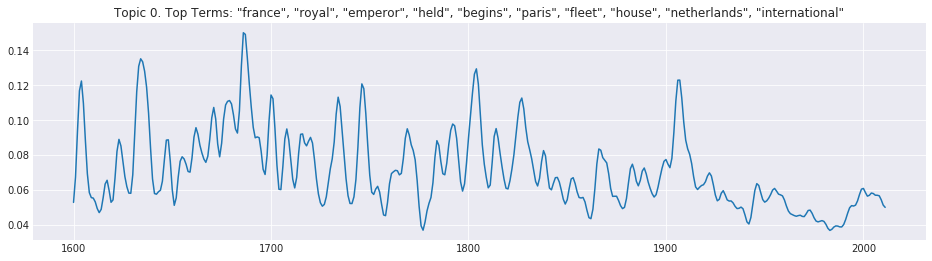

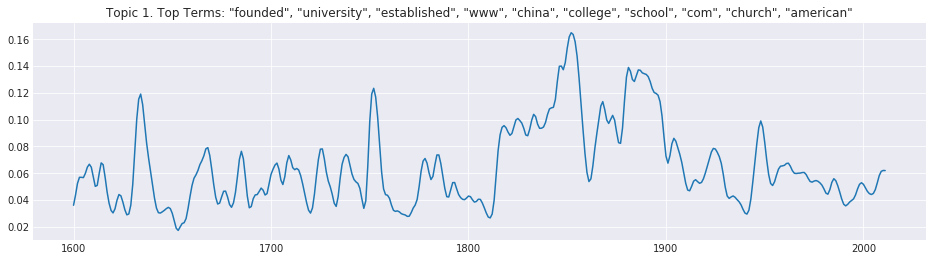

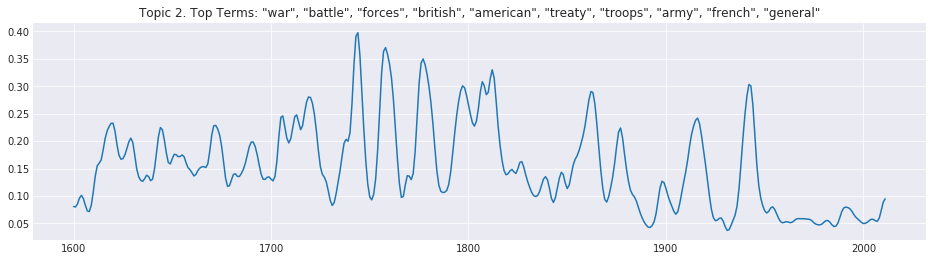

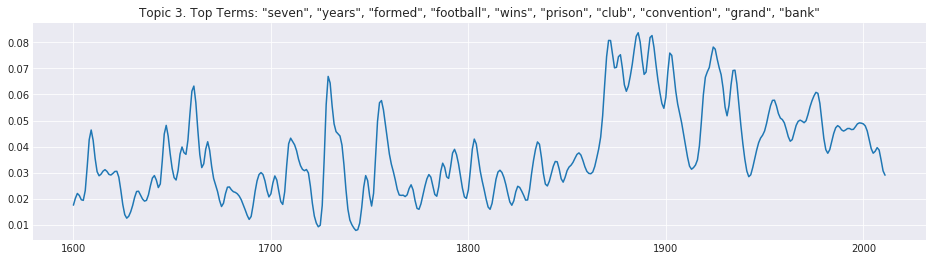

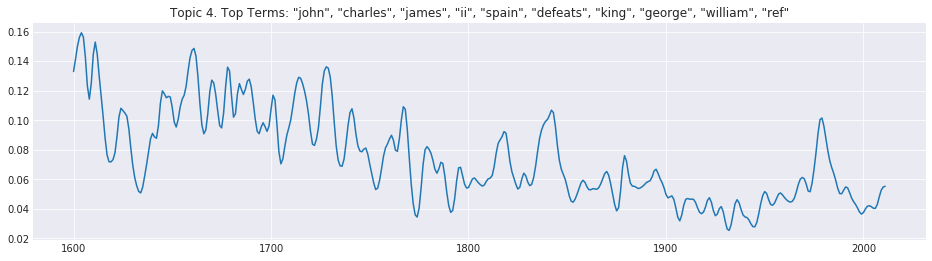

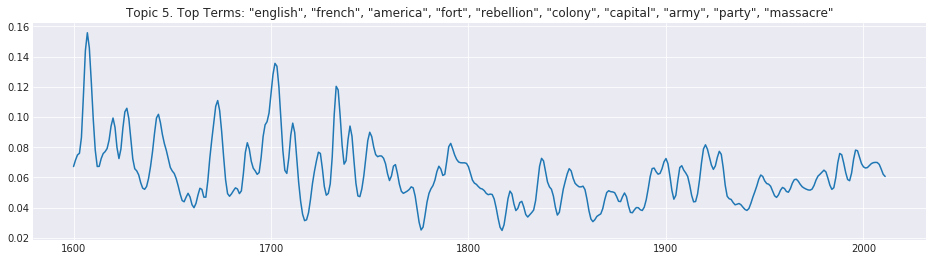

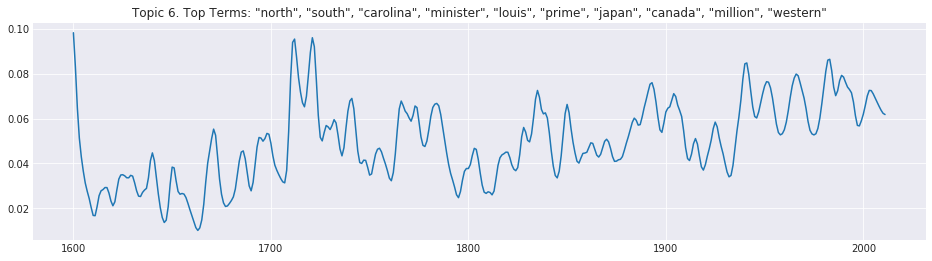

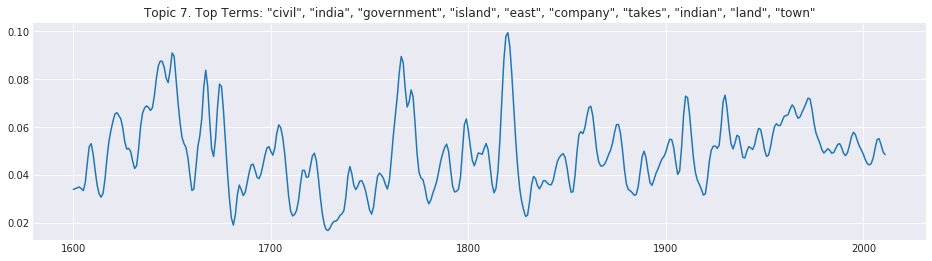

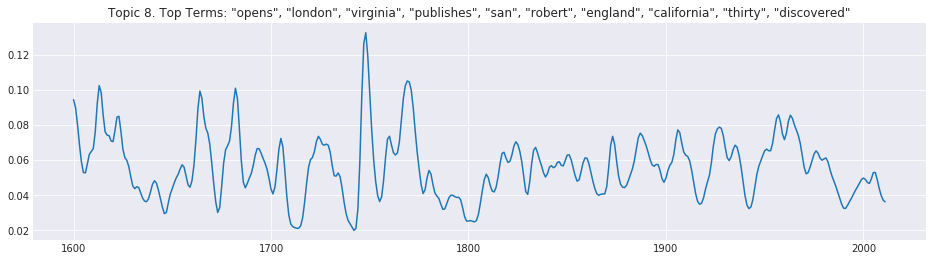

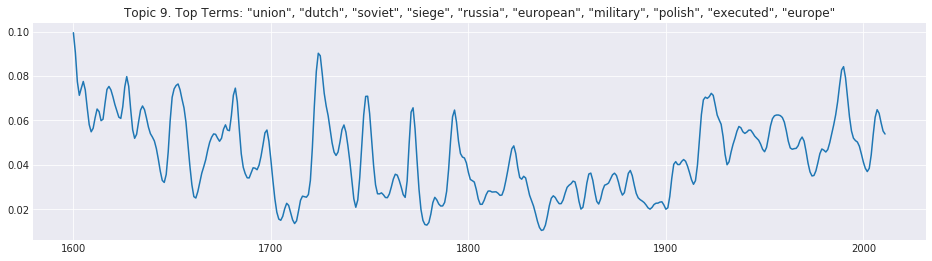

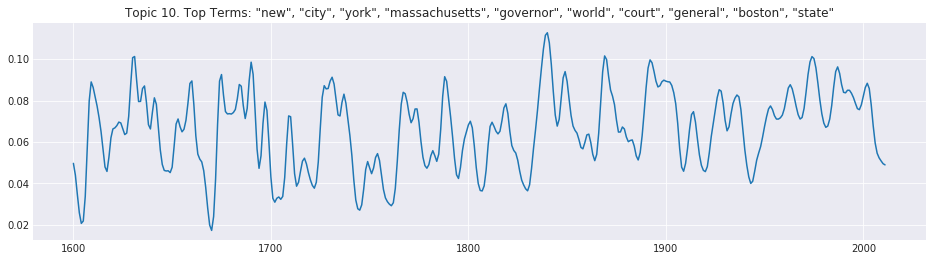

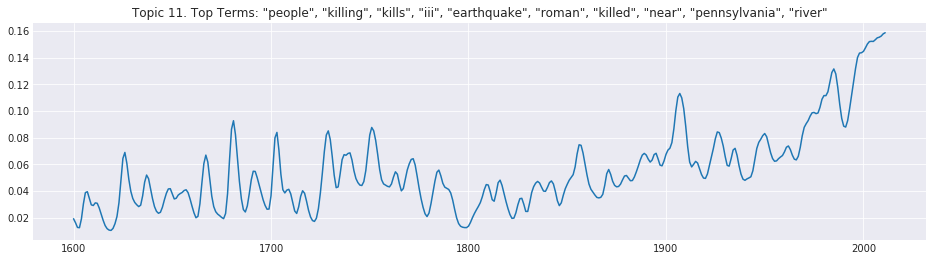

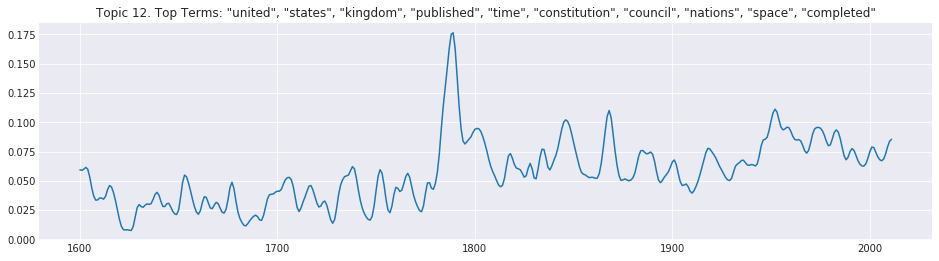

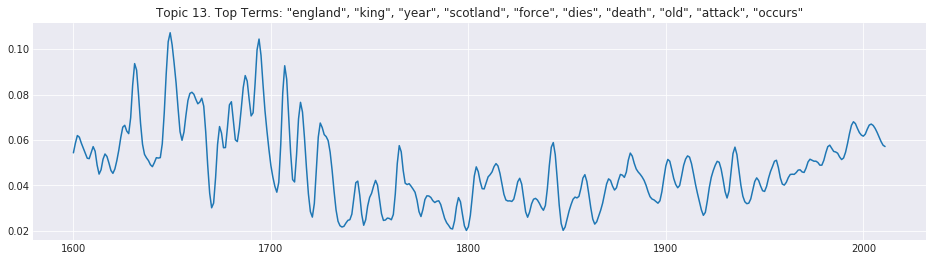

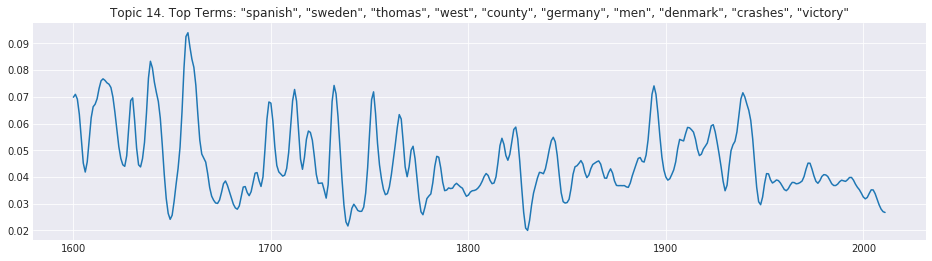

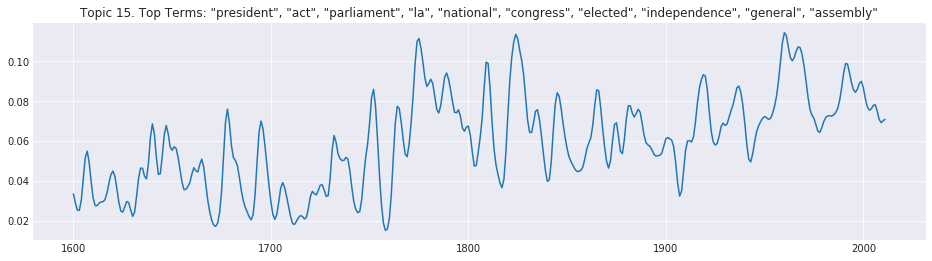

In [19]:
for top in range(num_topics):
    terms = [id2word[id] for id, _ in lda.get_topic_terms(top)]
    x = list(topics_by_year.keys())
    y = [tops[top] for tops in topics_by_year.values()]
    for _ in range(4):
        y[0] = (y[0] + y[1]) / 2
        for i in range(1, len(y) - 1):
            y[i] = (y[i - 1] + y[i] + y[i + 1]) / 3
        y[-1] = (y[-2] + y[-1]) / 2
#     spl = UnivariateSpline(x, y)
#     spl.set_smoothing_factor(0.3)
    plt.figure(figsize=(16,4))
    plt.title('Topic {}. Top Terms: "{}"'.format(top, '", "'.join(terms)))
#     plt.plot(x, spl(x));
    plt.plot(x, y);

In [ ]:
# def string_to_vec(string):
#     vec = [0] * num_topics
#     for top, score in get_doc_topics(string):
#         vec[top] = score
#     return vec

# X = []
# y = []
# for mdoc in collection.find():
#     year = mdoc['year']
#     vec = string_to_vec(mdoc['description'])
#     X.append(vec)
#     y.append(year)
    
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# nn = MLPRegressor(hidden_layer_sizes=(num_topics * 2,))
# nn.fit(X_train, y_train)
# nn.score(X_test, y_test)

In [ ]:
# nn.predict([string_to_vec('George Bush went to Iraq.')])

In [25]:
pyLDAvis.gensim.prepare(lda, corpus, corpora.Dictionary.from_corpus(corpus, id2word=id2word))

2018-05-30 21:06:03,853 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-05-30 21:06:04,027 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2018-05-30 21:06:04,125 : INFO : adding document #20000 to Dictionary(0 unique tokens: [])
2018-05-30 21:06:04,185 : INFO : built Dictionary(1802 unique tokens: ['hawaii', 'republican', 'national', 'convention', 'electric']...) from 23911 documents (total 164395 corpus positions)
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.173163  0.082328       1        1  9.843038
10    -0.026142  0.103375       2        1  7.296626
15     0.083060  0.247693       3        1  6.847452
11     0.041852 -0.212861       4        1  6.665764
12     0.014936  0.228610       5        1  6.611281
5      0.099047 -0.038196       6        1  6.515528
6      0.136365 -0.158945       7        1  6.330596
4     -0.278173  0.035901       8        1  6.000297
7      0.142935 -0.025758       9        1  5.853054
1     -0.022114  0.029587      10        1  5.720865
0      0.043330 -0.004586      11        1  5.675697
13    -0.204193 -0.140687      12        1  5.631207
14     0.087942 -0.183901      13        1  5.390900
9      0.017894  0.037731      14        1  5.373082
8     -0.218440 -0.000703      15        1  5.193887
3     -0.091461  0.000409      16        1  5.050731, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
18    Default  2039.000000       united  2039.000000  30.0000  30.0000
45    Default  1954.000000          war  1954.000000  29.0000  29.0000
19    Default  1619.000000       states  1619.000000  28.0000  28.0000
6     Default  1556.000000          new  1556.000000  27.0000  27.0000
161   Default  1050.000000      founded  1050.000000  26.0000  26.0000
51    Default  1103.000000    president  1103.000000  25.0000  25.0000
76    Default  1181.000000       battle  1181.000000  24.0000  24.0000
530   Default  1079.000000      england  1079.000000  23.0000  23.0000
267   Default   782.000000        north   782.000000  22.0000  22.0000
213   Default   751.000000       france   751.000000  21.0000  21.0000
217   Default   760.000000         king   760.000000  20.0000  20.0000
633   Default   549.000000        union   549.000000  19.0000  19.0000
226   Default   670.000000       forces   670.000000  18.0000  18.0000
24    Default   750.000000       people   750.000000  17.0000  17.0000
50    Default   567.000000      killing   567.000000  16.0000  16.0000
48    Default   549.000000        south   549.000000  15.0000  15.0000
1030  Default   547.000000      english   547.000000  14.0000  14.0000
8     Default   814.000000         city   814.000000  13.0000  13.0000
7     Default   557.000000         york   557.000000  12.0000  12.0000
225   Default   917.000000       french   917.000000  11.0000  11.0000
333   Default   509.000000        civil   509.000000  10.0000  10.0000
40    Default   500.000000   university   500.000000   9.0000   9.0000
1019  Default   480.000000      spanish   480.000000   8.0000   8.0000
715   Default   497.000000     carolina   497.000000   7.0000   7.0000
67    Default   459.000000      kingdom   459.000000   6.0000   6.0000
11    Default   670.000000         john   670.000000   5.0000   5.0000
277   Default   426.000000        royal   426.000000   4.0000   4.0000
79    Default   666.000000         army   666.000000   3.0000   3.0000
66    Default   521.000000       treaty   521.000000   2.0000   2.0000
134   Default   619.000000   government   619.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
366   Topic16   149.809723        grand   150.741043   2.9794  -4.0150
460   Topic16   144.463745         bank   145.395065   2.9792  -4.0513
81    Topic16   137.415726       league   138.347046   2.9789  -4.1014
736   Topic16   135.933807     portugal   136.865128   2.9788  -4.1122
1102  Topic16   133.901901       called   134.833221   2.9787  -4.1273
656   Topic16   126.073792    alexander   127.005119   2.9783  -4.1875
1184  Topic16   124.184540      granted   125.115868   2.9782  -4.2026
476   Topic16   122.888474       series   123.819809   2.9781  -4.2131
1603  Topic16   119.193069       samuel   120.124397   2.9779  -4.2436
485   Topic16   112.1